Продемонстрируем работу различных стратегий (жадной, 𝜺-жадной, UCB, выборки Томпсона) на примере задачи о k-руком бандите. 

Сначала рассмотрим работу двух стратегий: 𝜺-жадной и жадной в следующей постановке. Рассмотрим десятирукого бандита, инициализируем его следующим образом: 
    
    Каждому рычагу сопоставим одну из 10 случайных величин, распределённых нормально с дисперсией 1 и некоторым математическим ожиданием. 
    Для инициализации математических ожиданий, выберем случайно 10 чисел, распределенных также по нормальному закону со средним 0 и стандартным отклонением 1. Выбор k-го рычага даёт вознаграждение, которое является реализацией k-ой случайной величины.

Задача заключается в поиске стратегии для максимизации полученного дохода за 1000 шагов.

Технически, 𝜺-жадная стратегия реализуется следующим образом. На каждом шаге требуется принять решение: будет ли использоваться полученное знание или будет проводиться исследование. Для этого генерируется случайное число между нулём и единицей и сравнивается с параметром 𝜺. Если значение оказывается меньше 𝜺, то проводится исследование, то есть выбирается один рычаг из десяти равновероятно. Если же значение оказывается больше 𝜺, то используем жадный алгоритм, который выбирает максимальное значение из уже известных оценок (если таких несколько, то выбор случаен). 

На каждом шаге оценка ценности действия считается по методу выборочного среднего, то есть как усреднённая сумма всех предыдущих вознаграждений, полученных для данного действия с помощью инкрементной реализации: зафиксируем действие $a$

$Q_{n+1} = Q_n + \frac 1n (r_n - Q_n),$  где $r_n$ это вознаграждение, полученное после n-го выбора этого действия, $Q_n$ оценка ценности действия $a$.

Под одним прогоном задачи будем понимать инициализацию истинных вознаграждений и 1000 выборов рычага (действий). В каждом прогоне вычислим полученный доход (сумму всех вознаграждений) и процент оптимальных выборов. 

Поскольку задача зависит от случайных параметров, усредним полученные значения дохода и процента оптимальных действий по 2000 прогонам для получения более объективного сравенния стратегий.

Программно среда (то есть десятирукий бандит) будет реализован как класс Bandit с методами:
1.   reset() для сброса полей
2.   step() для осуществления действия и обновления оценок

Агент также будет реализован как класс Agent с методами
1.   reset() для сброса полей
2.   get_action() для выбор действия по 𝜺-жадной стратегии
3.   update() для обновления оценок

# Основной код

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #для отображения шкалы выполнения цикла

class Bandit:
    # k: число рук
    def __init__(self, k=10):
        self.k = k
        self.indices = np.arange(k) # массив с индексами рычагов        
        self.q_true = np.random.randn(k) # истинные ценности действий      
        self.best_action = np.argmax(self.q_true) # истинное лучшее действие
        
    # обновление параметров   
    def reset(self):
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true)

    # осуществление действия, получение вознаграждения
    def step(self, action):
        # вознаграждение из нормального распределения N(q_true[action], 1)
        reward = np.random.randn() + self.q_true[action]
        return reward
    
    
class Agent:
    # epsilon: параметр eps-жадной стратегии
    # possible_acts: информация о возможных действия в среде
    def __init__(self, epsilon, possible_acts):
        self.actions = possible_acts
        self.epsilon = epsilon
        # число действий
        self.k = len(self.actions)
        # оценки ценности действий
        self.q_estimation = np.zeros(self.k) 
        # число выборов каждого действия
        self.action_count = np.zeros(self.k)
        
    # обновление параметров  
    def reset(self):
        self.q_estimation = np.zeros(self.k) 
        self.action_count = np.zeros(self.k)
        
    # выбор eps-жадного действия
    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)

        q_best = np.max(self.q_estimation)
        return np.random.choice(self.actions[self.q_estimation == q_best])
        # возвращает индексы элементов, где выполняется условие равенства.

    def update(self, action, reward):      
        self.action_count[action] += 1      
        # обновление оценки действия
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]  
    
# специальная функция для запуска симуляции, 
# input: число прогонов, число шагов в прогоне, экземпляры классов Bandit и Agent
def simulate(runs, time, bandit, agent):
    rewards = np.zeros((runs, time)) #массив вознаграждений
    best_action_counts = np.zeros(rewards.shape) #массив с метками о выборе лучшего действия
    for r in tqdm(range(runs)):
        # сброс полей
        bandit.reset()
        agent.reset()
        for t in range(time):
            act=agent.get_action() # действие
            rew = bandit.step(act) # получение вознаграждения
            agent.update(act,rew) # обновление оценок
            rewards[r, t] = rew
            if act == bandit.best_action:
                best_action_counts[r, t] = 1
    # усреднение по прогонам
    mean_best_action_counts = best_action_counts.mean(axis=0)
    mean_rewards = rewards.mean(axis=0)
    return mean_best_action_counts, mean_rewards

In [2]:
   # проверка 1
bandit = Bandit(10)
agent = Agent(0.0, bandit.indices)
bandit.reset()
agent.reset()
print("Истинные ценности: ",bandit.q_true)
print("Лучший рычаг (нумерация с 0): ",bandit.best_action)
print("\
      ")
act=agent.get_action()
rew = bandit.step(act)
agent.update(act,rew)
print("Шаг 1. Выбор рычага по eps-жадной стратегии: ", act)
print("Полученная награда", rew)
print("Вектор оценок", agent.q_estimation)

act=agent.get_action()
rew = bandit.step(act)
agent.update(act,rew)
print("Шаг 2. Выбор рычага по eps-жадной стратегии: ", act)
print("Полученная награда", rew)
print("Вектор оценок", agent.q_estimation)

Истинные ценности:  [ 0.34610788  1.75586927  0.34417877  0.40820004 -0.01471523  0.49495794
 -1.3252092  -0.52680173 -0.21367729  1.56732026]
Лучший рычаг (нумерация с 0):  1
   
Шаг 1. Выбор рычага по eps-жадной стратегии:  0
Полученная награда -0.7596777125690379
Вектор оценок [-0.75967771  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
Шаг 2. Выбор рычага по eps-жадной стратегии:  3
Полученная награда 0.1276885928671891
Вектор оценок [-0.75967771  0.          0.          0.12768859  0.          0.
  0.          0.          0.          0.        ]


In [3]:
# проверка 2
bandit.reset()
agent.reset()
acts=[]
for i in range(10):
    act=agent.get_action()
    rew = bandit.step(act)
    agent.update(act,rew)
    acts.append(act)
print("Вектор выбранных действий за 10 шагов:", acts)
print("Вектор оценок после 10 шагов:", agent.q_estimation)

Вектор выбранных действий за 10 шагов: [2, 3, 9, 0, 0, 0, 0, 0, 0, 0]
Вектор оценок после 10 шагов: [ 0.24009301  0.         -0.86426291 -1.52614427  0.          0.
  0.          0.          0.         -2.22586475]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.38it/s]

Число шагов: 1000


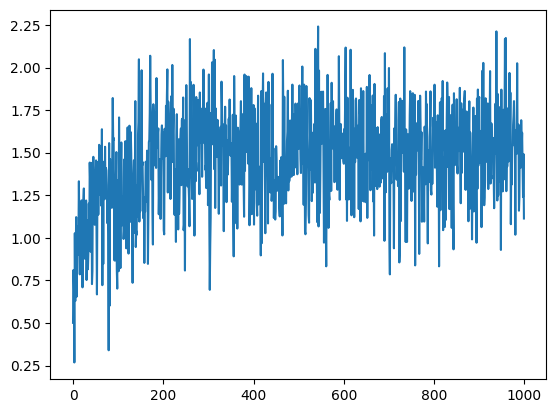

In [4]:
# проверка 3
runs=20
time=1000
bandit = Bandit(10)
agent = Agent(0.1, bandit.indices)

best_action_counts, rewards = simulate(runs, time, bandit, agent)
print("Число шагов:", len(rewards))
plt.plot(rewards, label='epsilon')

In [5]:
agent.q_estimation

array([ 0.29692863,  0.3293506 , -0.24298497,  0.73829906, -1.03253982,
       -0.04279175,  0.83415729,  0.13193356, -1.76069462,  0.48293321])

In [6]:
bandit.q_true

array([ 0.40769136,  0.83604098, -0.25137481,  0.97514595, -0.83362279,
       -0.37371783,  0.78418937,  0.5677566 , -1.57421883,  0.68581384])

### Сравнение стратегий

Сравним 𝜺-жадную и жадную стратегии

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.67it/s]


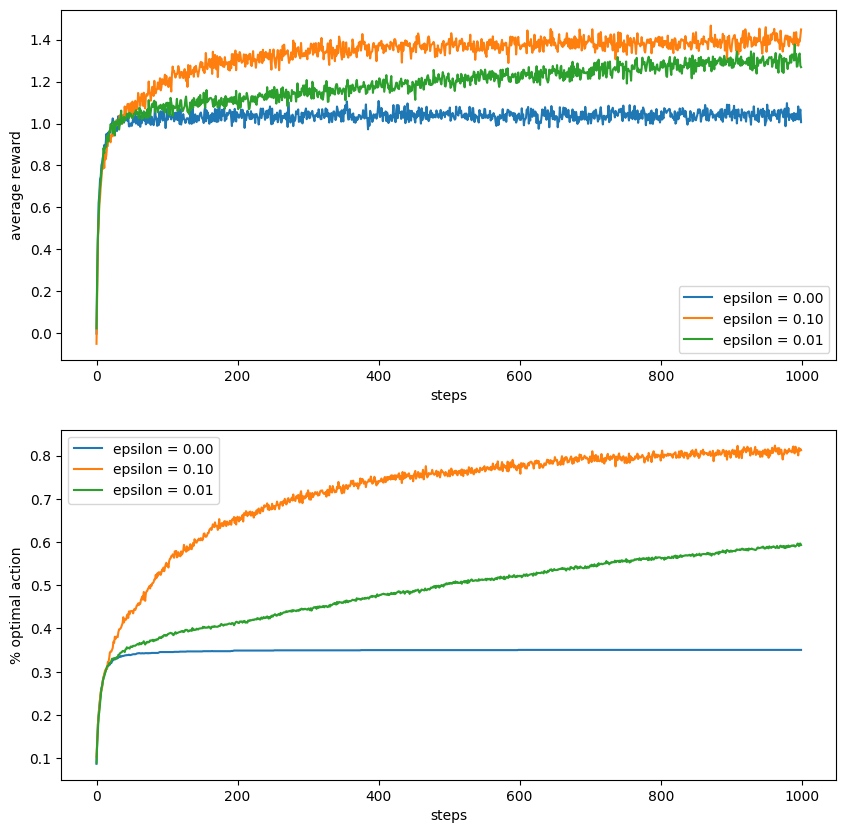

In [7]:
# Запуск 2000 прогонов
runs=2000
time=1000
bandit = Bandit(10)
epsilons = [0, 0.1, 0.01]
agents = [Agent(eps, bandit.indices) for eps in epsilons]
rewards=np.zeros((len(epsilons),time))
best_action_counts = np.zeros((len(epsilons),time))

for i, agent in enumerate(agents):
    best_action_counts[i], rewards[i] = simulate(runs, time, bandit, agent)

plt.figure(figsize=(10,10))     
plt.subplot(2, 1, 1)
for eps, rews in zip(epsilons, rewards):
    plt.plot(rews, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()



plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

## Модификация кода - задание

Изменим код Bandit, чтобы добавить опцию изменять истинные оценки ценности действий

Изменим код Agent, чтобы добавить несколько опций:
1. случай постоянного размера шага обновления
2. случай оптимистичного старта
3. случай выбора с верхней допустимой границей

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
class Bandit:
    # k: число рук
    # Q_changed: флаг, меняются ли истинные ценности действий
    def __init__(self, k=10, Q_changed=False):
        self.k = k
        self.Q_changed = Q_changed
        self.indices = np.arange(k) # массив с индексами рычагов        
        self.q_true = np.random.randn(k) # истинные ценности действий       
        self.best_action = np.argmax(self.q_true) # истинное лучшее действие        
        
    # обновление параметров   
    def reset(self):
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true)

    # осуществление действия, получение вознаграждения
    def step(self, action):
        # изменение истинных ценностей
        if self.Q_changed == True:
            self.q_true +=  np.random.normal(0, 0.01, self.k)
            self.best_action = np.argmax(self.q_true)
        # вознаграждение из нормального распределения N(q_true[action], 1)
        reward = np.random.randn() + self.q_true[action]
        return reward
    
    
class Agent:  
    # epsilon: параметр epsilon
    # initial: начальные оценки (для теста оптимистичного старта)
    # step_size: размер шага
    # sample_averages: флаг, если да, то считаются выборочные средние, если нет, 
    #    то в формуле обновления оценк используется постоянный размер шага
    # UB: флаг, если да, то использовать ВДГ, если нет, то не использовать
    def __init__(self,epsilon=0.,possible_acts=np.arange(10),initial=0.,sample_averages=True,step_size=0.1, UB=False):
        self.epsilon = epsilon
        self.actions = possible_acts       
        self.initial = initial
        self.step_size = step_size       
        self.sample_averages = sample_averages       
        self.UB = UB
        self.UB_param = 2 # параметр ВДГ
        self.k = len(self.actions) # число действий              
        self.time = 0 # счётчик для дискретных шагов        
        self.q_estimation = np.zeros(self.k) + self.initial  # оценки ценности действий со сдвигом        
        self.action_count = np.zeros(self.k) # число выборов каждого действия
        
    # обновление параметров  
    def reset(self):
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.time = 0
        
    # выбор действия
    def get_action(self):
        # либо по ВДГ
        if self.UB == True:
            UCB_estimation = [
                q  + self.UB * np.sqrt(np.log(self.time) / a)
                if a != 0
                else
                float("inf")
                for q, a in zip(self.q_estimation, self.action_count)
            ]
            q_best = np.argmax(UCB_estimation)
            return self.actions[q_best]
        
        # либо eps-жадно
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)

        q_best = np.max(self.q_estimation)
        return np.random.choice(self.actions[self.q_estimation == q_best])

    # обновление оценок
    def update(self, action, reward):      
        self.time += 1
        self.action_count[action] += 1      
        # обновление оценки действия
        if self.sample_averages:
            # обновление по формуле выборочных средних
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
    
        else:
            # обновление с постоянным шагом
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])

In [10]:
# специальная функция для запуска симуляции при нескольких агентах, 
# input: число прогонов, число шагов в прогоне, экземпляр класса Bandit и экземпляры Agent
def simulate_all(runs, time, bandit, agents):
    rewards = np.zeros((len(agents), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    # прогон для каждого агента
    for i, agent in enumerate(agents):
        for r in tqdm(range(runs)):
            bandit.reset()
            agent.reset()
            for t in range(time):
                act = agent.get_action()
                rew = bandit.step(act)
                agent.update(act,rew)
                rewards[i, r, t] = rew
                if act == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

Повторим эксперимент сделанный выше с новыми классами.

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:36<00:00, 40.89it/s]


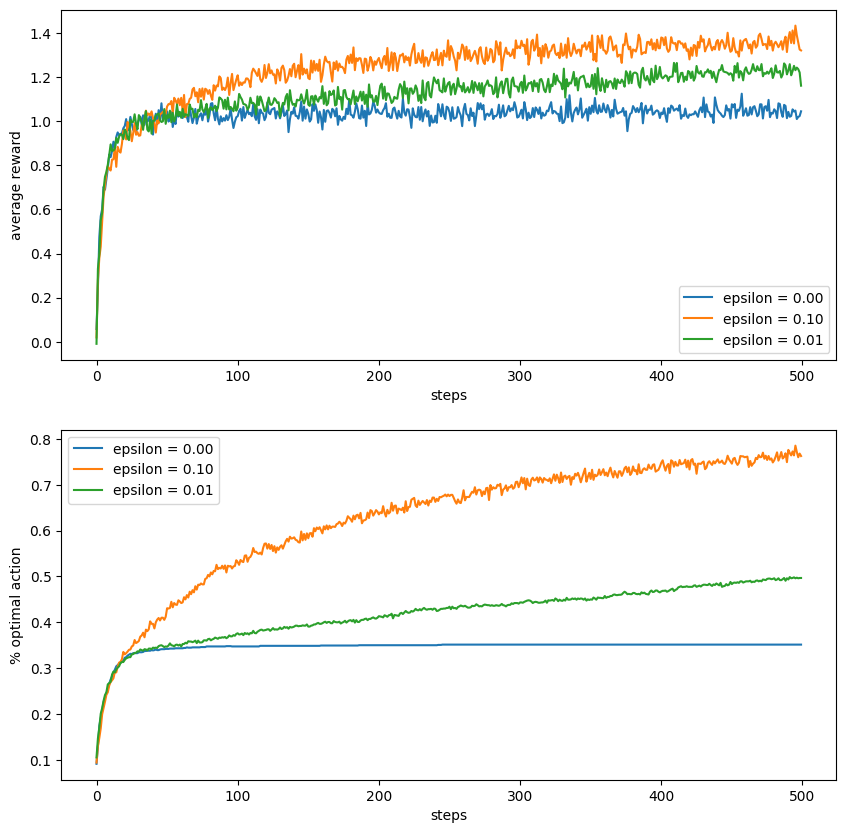

In [11]:
# Запуск 1500 прогонов
runs=1500
time=500
epsilons = [0, 0.1, 0.01]
bandit = Bandit(10)

agents = [Agent(epsilon=eps) for eps in epsilons]

best_action_counts, rewards = simulate_all(runs, time, bandit, agents)

plt.figure(figsize=(10,10))     
plt.subplot(2, 1, 1)
for eps, rews in zip(epsilons, rewards):
    plt.plot(rews, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

### Сравнение стратегий

Далее, рассмотрим работу агентов:
 
     1-2. с eps-жадной и жадной стратегией
     3-4. с eps-жадной и жадной стратегией, но оптимистическими стартами

In [12]:
runs=500
time=800
bandit = Bandit(10)

agents = []
agents.append(Agent(epsilon=0, initial=5))
agents.append(Agent(epsilon=0.1, initial=5))
agents.append(Agent(epsilon=0, initial=0))
agents.append(Agent(epsilon=0.1, initial=0))

best_action_counts, rewards = simulate_all(runs, time, bandit, agents)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.77it/s]


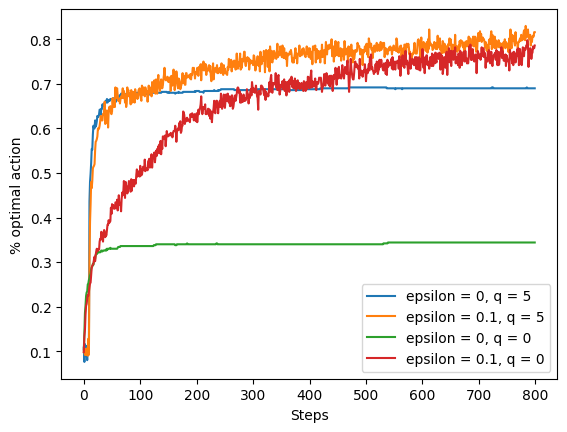

In [13]:
plt.plot(best_action_counts[0], label='epsilon = 0, q = 5')
plt.plot(best_action_counts[1], label='epsilon = 0.1, q = 5')
plt.plot(best_action_counts[2], label='epsilon = 0, q = 0')
plt.plot(best_action_counts[3], label='epsilon = 0.1, q = 0')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

In [14]:
best_action_counts[0][0:11]

array([0.108, 0.076, 0.116, 0.1  , 0.112, 0.094, 0.08 , 0.098, 0.112,
       0.108, 0.436])

На графиках процентов оптимальных действий для задачи многорукого бандита с оптимистичными стартами пик находится на 11 отсчёте. Это вполне ожидаемо, так как после того как опробованы все 10 рычагов, большая оценка вознаграждения чаще всего будет у рычага с самым большим истинным вознаграждением.

### Сравнение стратегий в нестационарном случае

Далее, продемонстрируем, что постоянный размер шага лучше подходит для нестационарного случая, когда с течением времени меняются истинные вознаграждения

In [ ]:
runs=1500
time=2000
bandit = Bandit(10, Q_changed=True)

agents = []
agents.append(Agent(epsilon=0.1, sample_averages=False, step_size=0.1)) # постоянный размер шага
agents.append(Agent(epsilon=0.1))  # оценки по выборочному среднему, шагу убывает как 1/n

best_action_counts, rewards = simulate_all(runs, time, bandit, agents)

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1437/1500 [03:01<00:07,  8.49it/s]

In [ ]:
plt.figure(figsize=(10,10))     
plt.subplot(2, 1, 1)
plt.plot(rewards[0], label='step_size = const')
plt.plot(rewards[1], label='step_size = nonconst')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()



plt.subplot(2, 1, 2)
plt.plot(best_action_counts[0], label='step_size = const')
plt.plot(best_action_counts[1], label='step_size = nonconst')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

### Сравнение eps-жадной и ВДГ-стратегии

Далее, продемонстрируем сравнение eps-жадной стратегии и стратегии, основанной на ВДГ-действии.

In [ ]:
runs=2000
time=1000
bandit = Bandit(10)

agents = []
agents.append(Agent(epsilon=0, UB=True))
agents.append(Agent(epsilon=0.1))

best_action_counts, rewards = simulate_all(runs, time, bandit, agents)


In [ ]:
plt.plot(rewards[0], label='UCB c = 2')
plt.plot(rewards[1], label='epsilon greedy epsilon = 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

### Сравнение с выборкой Томпсона

Далее сравним методы eps-жадной стратегии и выборку Томпсона. Для этого опять же надо изменить код класса Bandit.
Для действия по eps-жадной стратегии будет использовать класс Agent выше. А для агента с сэмплированием Томпсона напишем отдельный класс.

In [ ]:
class Bandit_TS:
    # k: число рук
    # bandit_probs: вектор вероятностей успехов
    def __init__(self, k=10):
        self.k = k
        self.indices = np.arange(k) # массив с индексами рычагов
        # истинные ценности действий (вероятности от 0 до 0.5)
        self.q_true = 0.5*np.random.rand(k)
        # истинное лучшее действие
        self.best_action = np.argmax(self.q_true)
        
    # обновление параметров   
    def reset(self):
        self.q_true = np.random.rand(self.k)
        self.best_action = np.argmax(self.q_true)

    # осуществление действия, получение вознаграждения
    def step(self, act):
        # вознаграждение из биномиального распределения, выдаёт 0 или 1
        return np.random.binomial(1, self.q_true[act])   

In [ ]:
class Agent_TS:
    # @k: число рычагов    
    def __init__(self, k=10):
        self.k = k
        # число успехов для каждого рычага
        self.success_count = np.zeros(self.k)
        # число неудач для каждого рычага
        self.failure_count = np.zeros(self.k)
    
    def reset(self):
        self.success_count = np.zeros(self.k)
        self.failure_count = np.zeros(self.k)

    # получение действия
    def get_action(self):
        samples_list = []
                    
        # выборка оценок истинных вероятностей для каждого рычага
        samples_list = [
            np.random.beta(a=s+1, b=f+1, size=1) 
            for s, f in zip(self.success_count, self.failure_count)
        ]
                                
        # возврат рычага с максимальной оценкой
        return np.argmax(samples_list)
    
    def update(self, action, reward):          
        # обновление информации об успехах и неудачах
        self.success_count[action] += reward
        self.failure_count[action] = self.failure_count[action] - reward  + 1

In [ ]:
# defining a set of bandits with known probabilites
bandit_probs = [0.35, 0.40, 0.30, 0.25, 0.2, 0.15, 0.1, 0.12, 0.22, 0.37]


bandit = Bandit_TS(10)
bandit.q_true = bandit_probs
bandit.q_true

In [ ]:
# k_array для хранения выборов, reward_array для хранения нарград
k=10
N_ITER = 10000
k_array = np.zeros((k,N_ITER))
reward_array = np.zeros((k,N_ITER))

agent = Agent_TS(10)

agent.reset()

# loop generating draws
for iter in range(N_ITER):
    # choosing arm and drawing
    act = agent.get_action()
    reward = bandit.step(act)
    agent.update(act, reward)
    
    # record information about this draw
    #k_list.append(k)
    #reward_list.append(reward)
    k_array[act, iter] = 1
    reward_array[act, iter] = reward

In [ ]:
agent.success_count/(agent.success_count+agent.failure_count)

In [ ]:
bandit = Bandit_TS(10)
bandit.q_true = bandit_probs

agent_ts = Agent_TS(10)
agent_ts.reset()

agent_eps = Agent(epsilon=0.1, sample_averages=True)
agent_eps.reset()

agent_ucb = Agent(epsilon=0, sample_averages=True, UB=True)

agents = [agent_ts,agent_eps, agent_ucb]

runs=200
time = 2000

best_action_counts, rewards = simulate_all(runs, time, bandit, agents)

In [ ]:
plt.figure(figsize=(10,10))     
plt.subplot(2, 1, 1)
plt.plot(rewards[0], label='Agent_TS')
plt.plot(rewards[1], label='Agent_EPS')
plt.plot(rewards[2], label='Agent_UCB')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()



plt.subplot(2, 1, 2)
plt.plot(best_action_counts[0], label='Agent_TS')
plt.plot(best_action_counts[1], label='Agent_EPS')
plt.plot(best_action_counts[2], label='Agent_UCB')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()